In [1]:
import numpy as np
import pandas as pd
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt

#obtain hierarchical dataset
from datasetsforecast.hierarchical import HierarchicalData

# compute base forecast no coherent
from statsforecast.core import StatsForecast

/home/codespace/.python/current/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Vamos a estudiar la volatilidad de nuestros datos, para ver si hay alguna época en el que las reservas tengan un comportamiento anormal

In [3]:
df_w_r = pd.read_csv('df_reservas.csv')
df_w_r['ArrivalDate'] = pd.to_datetime(df_w_r['ArrivalDate'])
df_w_r = df_w_r.set_index('ArrivalDate')
df_w_r.tail()

,IsCanceled
ArrivalDate,
2017-08-06,703
2017-08-13,717
2017-08-20,797
2017-08-27,678
2017-09-03,349


In [4]:
# Calculate Weekly Logarithmic Return
df_w_r['log_ret'] =np.log(df_w_r.IsCanceled).diff()
df_w_r.tail()

,IsCanceled,log_ret
ArrivalDate,,
2017-08-06,703,-0.119205
2017-08-13,717,0.019719
2017-08-20,797,0.105779
2017-08-27,678,-0.161707
2017-09-03,349,-0.664075


El uso de utilizar log, se aplica para normalizar los datos. Diff es una formula usada normalmente para datos financieros, para ver porcentualmente los cambios que existen entre diferentes valores, como para ver la diferencia de precios de una acción. Trato de replicar este proceso en las reservas para ver sus diferencias por semanas. Con esto calculamos la Rentabilidad de una semana a otra, para ver si ha aumentado o disminuido.

In [5]:
# Squared Log return
# Proxy Volatility
df_w_r['Squared'] =df_w_r['log_ret']**2
df_w_r.tail()

,IsCanceled,log_ret,Squared
ArrivalDate,,,
2017-08-06,703,-0.119205,0.014210
2017-08-13,717,0.019719,0.000389
2017-08-20,797,0.105779,0.011189
2017-08-27,678,-0.161707,0.026149
2017-09-03,349,-0.664075,0.440996


Los eventos extremos pueden influir significativamente en las estimaciones de volatilidad, y el log al cuadrado de los rendimientos tiende a amplificar su influencia.

Text(0.5, 0.8, 'Volatilidad')

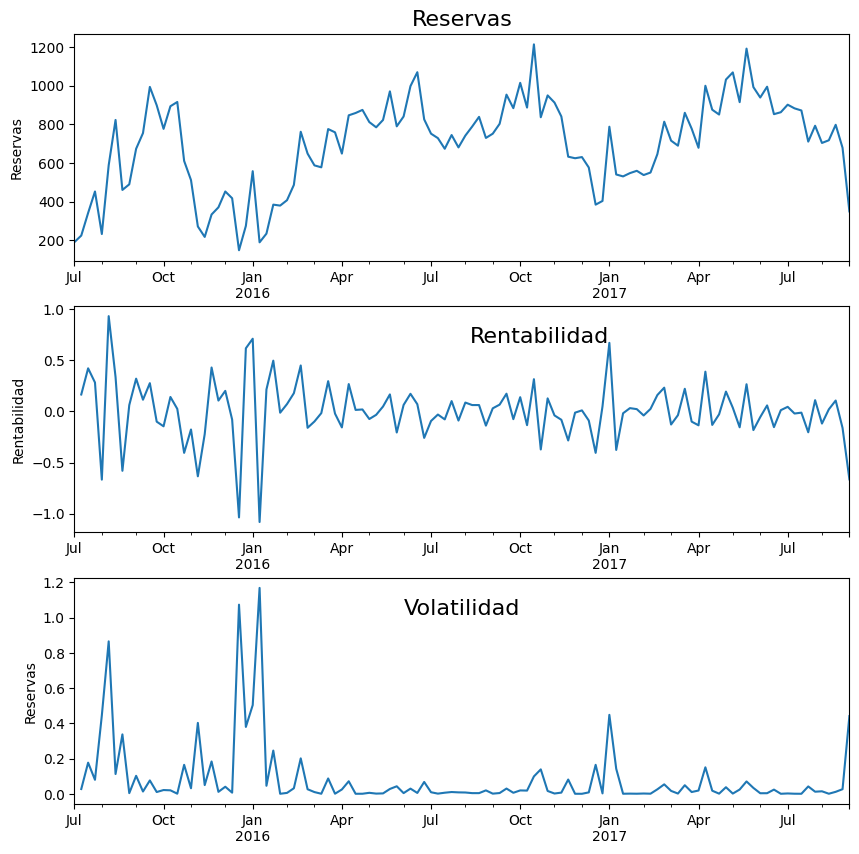

In [6]:
# Plot Return Squared
fig = plt.figure(figsize=(10,10))
plt.subplot(311)
ax=df_w_r.IsCanceled.plot( linestyle='-')
ax.set_ylabel('Reservas')
ax.set_xlabel('')
ax.set_title('Reservas', y=1, fontsize = 16)
plt.subplot(312)
ax=df_w_r.log_ret.plot( linestyle='-')
ax.set_ylabel('Rentabilidad')
ax.set_xlabel('')
ax.set_title('Rentabilidad', y=0.8, x=0.6,fontsize = 16)
plt.subplot(313)
ax=df_w_r.Squared.plot( linestyle='-')
ax.set_ylabel('Reservas')
ax.set_xlabel('')
ax.set_title('Volatilidad', y=0.8, fontsize = 16)

In [7]:
# Media -> Test
# mean zero test
from scipy import stats
alpha=0.05
t, p =stats.ttest_1samp(df_w_r['log_ret'].dropna(),0.0)
print ('Estadítico t:',t)
print ('p-value:',p)


# Condicional para que rechaze o no la hipotesis
if  p < alpha:
    print (f'Con {alpha} de significación: Rechazamos la hipotesis de media cero.')
else:
    print (f'Con {alpha} de significación: No podemos rechazar la hipotesis de media cero.')

Estadítico t: 0.19561349113328597
p-value: 0.8452671508398786
Con 0.05 de significación: No podemos rechazar la hipotesis de media cero.


No tenemos informacion suficiente para validar que la media de las observacion de test es igual a 0

### Vamos a ver ahora si tienen ruido blanco o no calculando las dos autocorrelaciones (acf y pacf)

En el análisis de series temporales, el ruido blanco se utiliza como modelo para los residuos o errores, lo que indica que un modelo de series temporales ha captado correctamente toda la información disponible y que los residuos son sólo fluctuaciones aleatorias.

In [8]:
# Autocorrelation Fuction Original Time Series
from sktime.utils.plotting import plot_correlations

In [9]:
# Create proxy Volatility 
reserves_vol=df_w_r['Squared'].astype('float64').to_period('D').sort_index().dropna()
reserves_vol.tail() 
#datos formato sktime

ArrivalDate
2017-08-06    0.014210
2017-08-13    0.000389
2017-08-20    0.011189
2017-08-27    0.026149
2017-09-03    0.440996
Freq: D, Name: Squared, dtype: float64

/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Squared'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

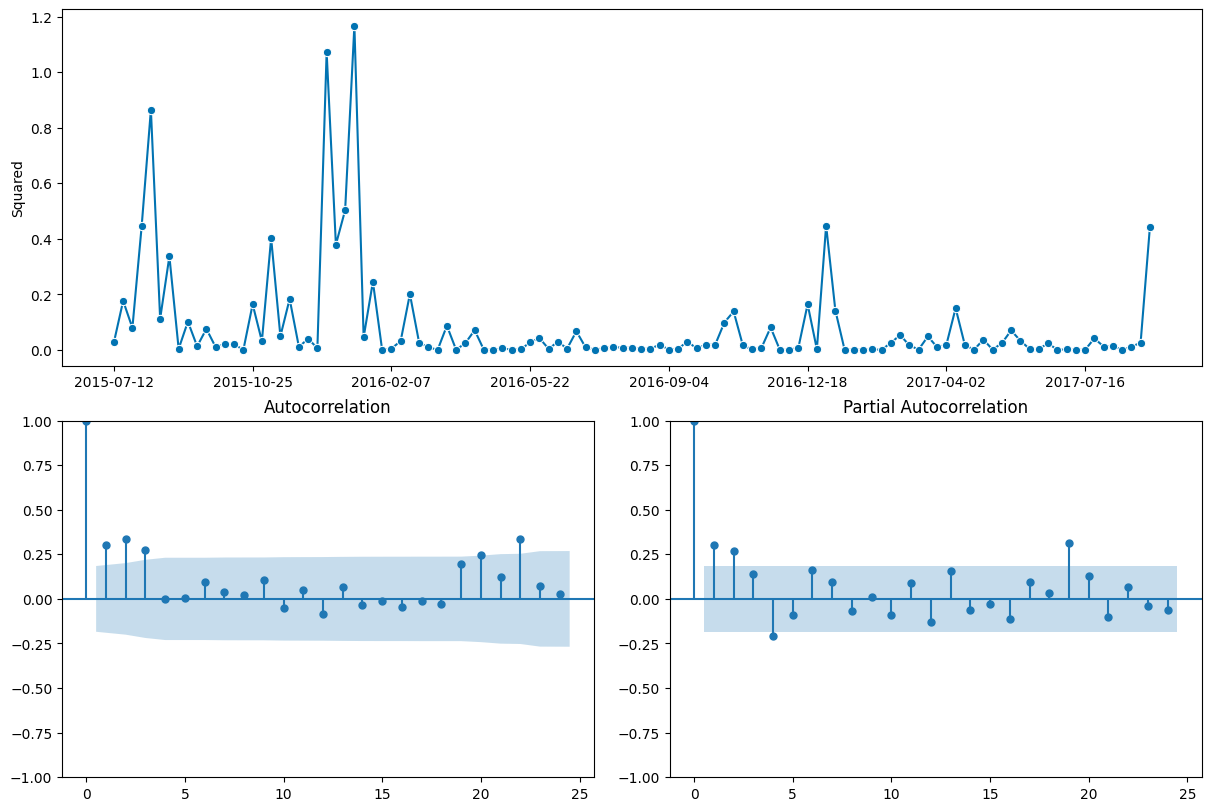

In [10]:
# Plot Autocorrelation
plot_correlations(reserves_vol)
# Estos son los rendimientos al cuadrado

Podemos ver como son ruido blanco, al tener los valores dentro de la banda rectangular azul. Bueno porque han captado la información disponible.

In [11]:
# import function test Ljung_Box
import statsmodels.api as sm
test_Ljung_Box=sm.stats.acorr_ljungbox

Ljung-Box, que es una prueba estadística para evaluar si las autocorrelaciones de residuos en una serie temporal son significativamente diferentes de cero (si no hay autocorrelacion). Este test es comúnmente utilizado en el análisis de residuos de modelos de series temporales para verificar la presencia de autocorrelación.

In [12]:
# testing Ljung-Box
# H0 NO GARCH, no hay
# H1 GARCH, si hay
# pvalue < alpha -> No Ruido Blanco -> GARCH
test_Ljung_Box(reserves_vol, lags=[4,8,12], return_df=True)

,lb_stat,lb_pvalue
4,31.941536,0.000002
8,33.090465,0.000059
12,35.513953,0.000388


Con los valores de pvalue cerca de cero, significa que rechaza la hipotesis nula, con lo que no hay autocorrelación.

#### LM-ARCH
El test de Ljung-Box modificado para heterocedasticidad condicional (LM-ARCH) es una prueba estadística utilizada para evaluar la presencia de heterocedasticidad condicional en una serie temporal, que se refiere a la variabilidad que cambia con el tiempo.

In [13]:
# import function test LM-Arch
import statsmodels.api as sm
test_LM_ARCH=sm.stats.diagnostic.het_arch

In [14]:
# testing LM-ARCH
# pvalue < alpha -> ARCH
lm, lmpval, f, pval, result_int =test_LM_ARCH(df_w_r['log_ret'].dropna(), nlags=4, store=True)
print ('Estadístico LM: ', lm)
print ('p-value: ', lmpval)
print ('Estadístico F: ', f)
print ('p-value: ', pval)

Estadístico LM:  23.589939932087784
p-value:  9.650479673515513e-05
Estadístico F:  7.181102995907012
p-value:  3.806855885589882e-05


En resumen, los valores pequeños de los p-values asociados tanto al estadístico LM como al estadístico F sugieren que hay evidencia significativa en contra de la hipótesis nula de homocedasticidad, indicando la presencia de heterocedasticidad condicional en los datos.

### Arch(1)

In [15]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 16.4 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.3 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
# Vamos a comprobar si coger el garch1 o 1,1. en la practica directamente garch 1,1

from arch.univariate import ARX
from arch.univariate import ARCH, GARCH

In [17]:
# Modelo para la Media un AR(1)
ar = ARX(100*df_w_r['log_ret'].dropna(), lags=[4]) #trabajando porcentual
print(ar.fit().summary()) # estimo con fit

                     AR - Constant Variance Model Results                     
Dep. Variable:                log_ret   R-squared:                       0.004
Mean Model:                        AR   Adj. R-squared:                 -0.005
Vol Model:          Constant Variance   Log-Likelihood:               -519.553
Distribution:                  Normal   AIC:                           1045.11
Method:            Maximum Likelihood   BIC:                           1053.18
                                        No. Observations:                  109
Date:                Wed, Dec 20 2023   Df Residuals:                      107
Time:                        12:05:41   Df Model:                            2
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          0.2973      2.696      0.110      0.912 [ -4.988,  5.58

/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

In [18]:
# MODELO ERRONEO
# ARCH(1)
ar.volatility = ARCH(p=1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

# se ve que hay ar, arch y distribucion normal

                           AR - ARCH Model Results                            
Dep. Variable:                log_ret   R-squared:                       0.003
Mean Model:                        AR   Adj. R-squared:                 -0.007
Vol Model:                       ARCH   Log-Likelihood:               -511.608
Distribution:                  Normal   AIC:                           1031.22
Method:            Maximum Likelihood   BIC:                           1041.98
                                        No. Observations:                  109
Date:                Wed, Dec 20 2023   Df Residuals:                      107
Time:                        12:05:42   Df Model:                            2
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          0.7385      2.488      0.297      0.767 [ -4.137,  5.61

/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

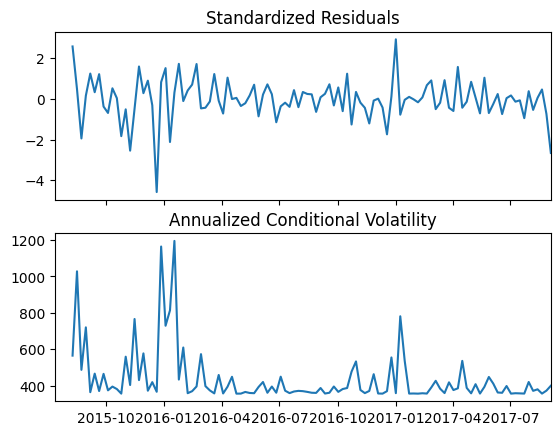

In [19]:
# dos resultado, el priimero es la z (residuos), el de abajo sigma que es la volatiliadd

fig = res.plot(annualize="D")

In [20]:
# Análisis de Residuos
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()

/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

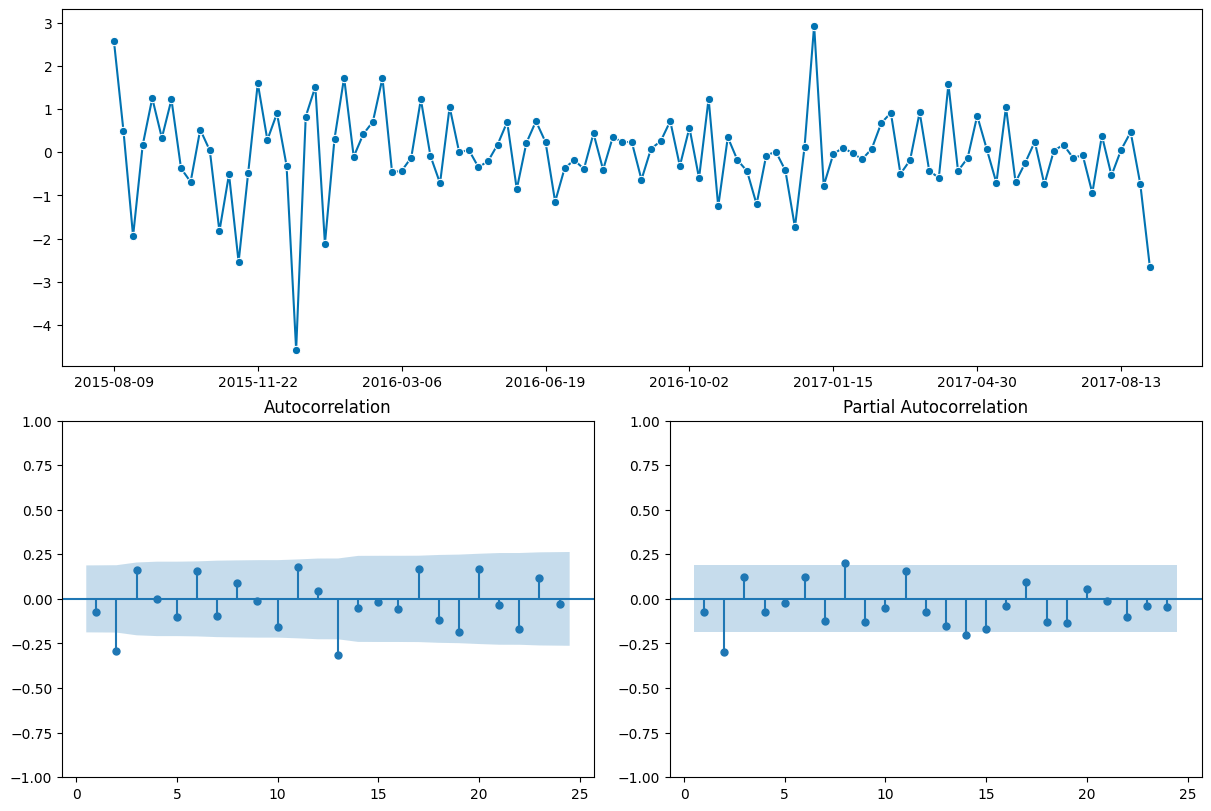

In [21]:
# Plot Autocorrelation , ver si es ruido balnco
plot_correlations(mod1_std_resid, zero_lag = False)

Se ve como esta en las bandas -> es ruido blanco

/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

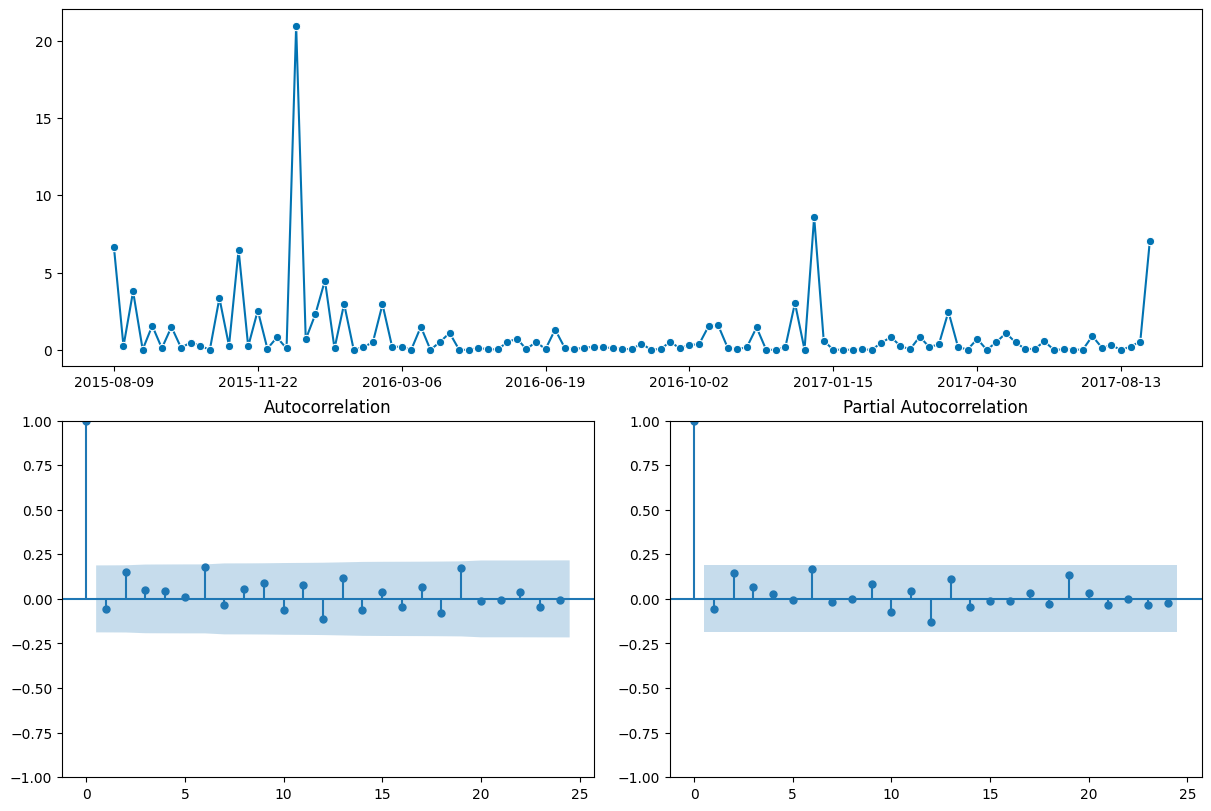

In [22]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid**2)

## Este vemos que no tiene ruido blanco, es incorrecto

In [23]:
# testing Ljung-Box
# pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(mod1_std_resid**2, lags=[10,20,30], return_df=True)

,lb_stat,lb_pvalue
10,8.198176,0.609486
20,15.869868,0.724664
30,17.227728,0.969742


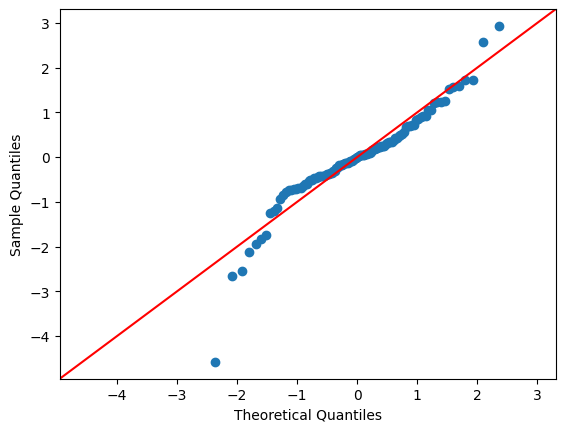

In [24]:
# qqplot (diferencia de los histogramas)
sm.qqplot(mod1_std_resid,line='45')
plt.show()

Ver si son normales, con el qqplot, cantidad de datos en un percentil. Si los datos son normales estarian en la linea roja.
Tener una distribucion normal y nuestros datos, hacer una diferencia. (Si son los mismos se quedaria en la linea)

### GARCH

In [25]:
# 
ar = ARX(100*df_w_r['log_ret'].dropna(), lags=[1])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                log_ret   R-squared:                       0.038
Mean Model:                        AR   Adj. R-squared:                  0.030
Vol Model:          Constant Variance   Log-Likelihood:               -534.651
Distribution:                  Normal   AIC:                           1075.30
Method:            Maximum Likelihood   BIC:                           1083.46
                                        No. Observations:                  112
Date:                Wed, Dec 20 2023   Df Residuals:                      110
Time:                        12:05:44   Df Model:                            2
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.6233      2.682      0.232      0.816   [ -4.63

/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

In [26]:
# MODELO 
# GARCH(1,1) poner el modelo 1,1
ar.volatility = GARCH(p=1,q=1)
res = ar.fit(update_freq=0, disp="off") # estimo
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                log_ret   R-squared:                       0.037
Mean Model:                        AR   Adj. R-squared:                  0.028
Vol Model:                      GARCH   Log-Likelihood:               -518.808
Distribution:                  Normal   AIC:                           1047.62
Method:            Maximum Likelihood   BIC:                           1061.21
                                        No. Observations:                  112
Date:                Wed, Dec 20 2023   Df Residuals:                      110
Time:                        12:05:44   Df Model:                            2
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.2828      2.058      0.137      0.891    [ -

/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

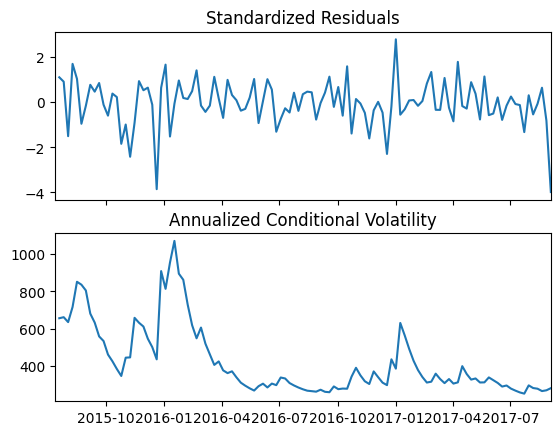

In [27]:
fig = res.plot(annualize="D")

In [28]:
# Análisis Residuos, calcular la z
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()

/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

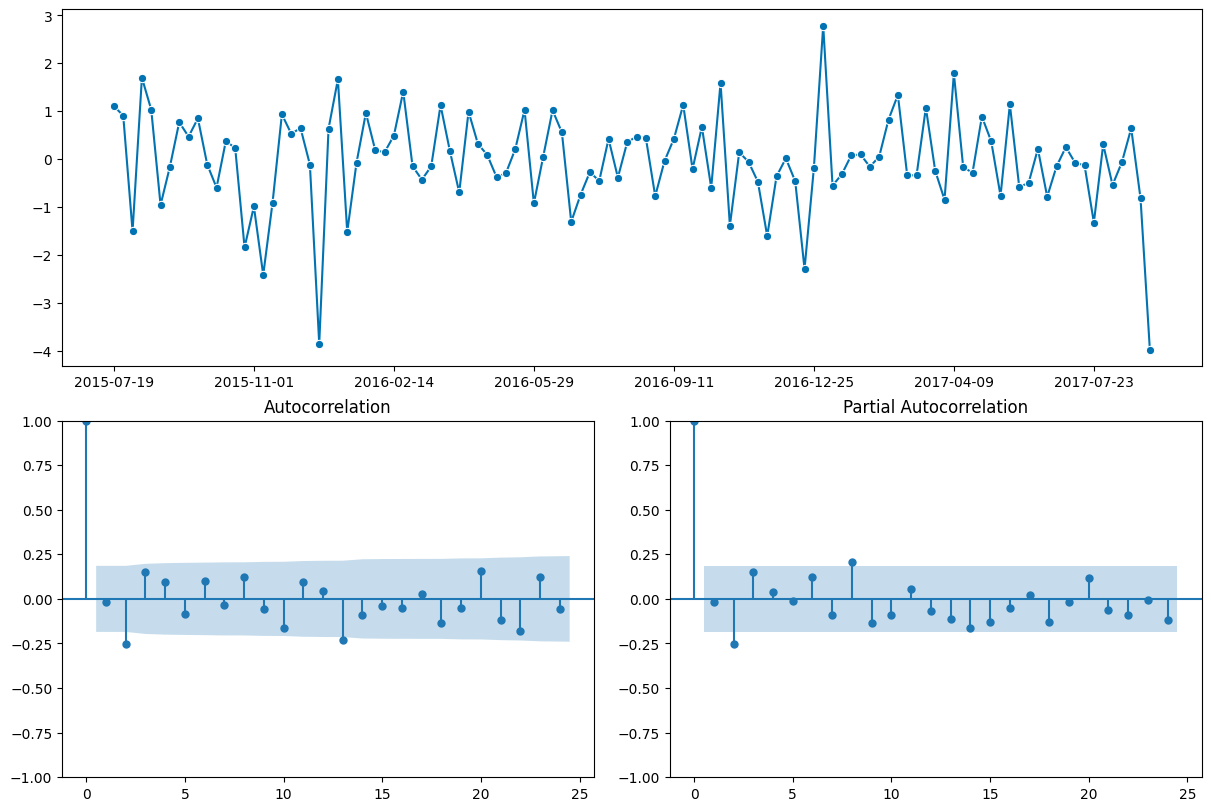

In [29]:
# Plot Autocorrelation, es ruido blanco?
plot_correlations(mod1_std_resid)

/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

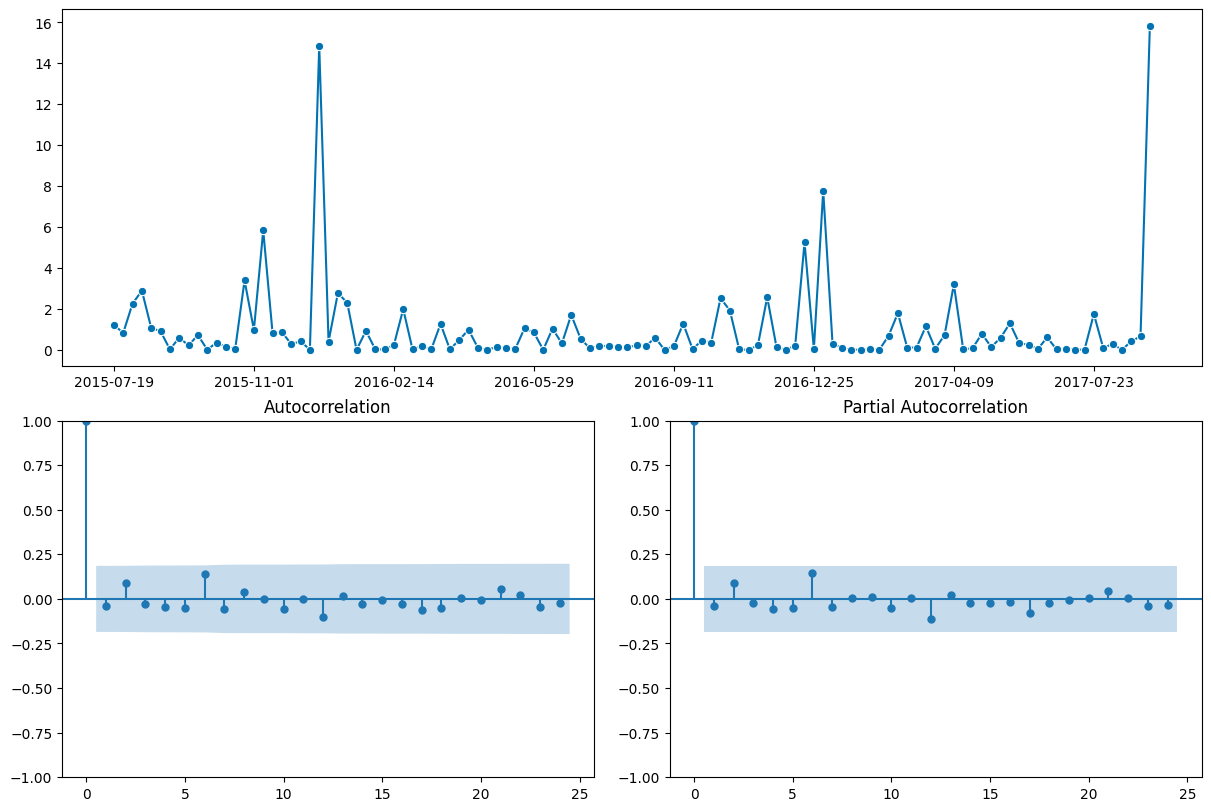

In [30]:
# Plot Autocorrelation, es garch
plot_correlations(mod1_std_resid**2)

No tiene problema de garch, por el modelo que hemos utilizado para estimar es correcto

In [31]:
# testing Ljung-Box
# pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(mod1_std_resid**2, lags=[4,8,12], return_df=True)
# si no es garch, valores altos

,lb_stat,lb_pvalue
4,1.409922,0.842469
8,4.304465,0.828662
12,5.653020,0.932554


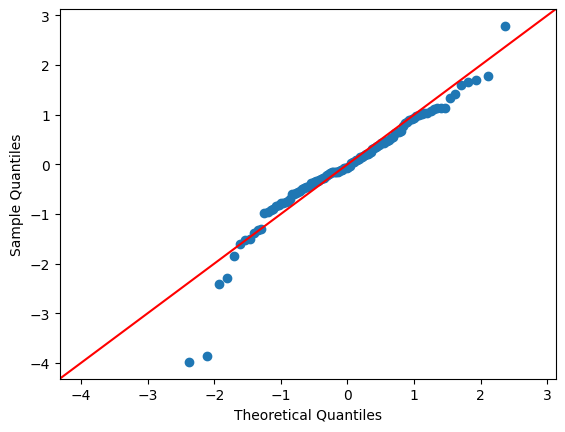

In [32]:
# qqplot
sm.qqplot(mod1_std_resid,line='45')
plt.show()

### Garch(1,1) + T-Student

In [33]:
from arch.univariate import StudentsT

In [34]:
ar.distribution = StudentsT()
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                      log_ret   R-squared:                       0.037
Mean Model:                              AR   Adj. R-squared:                  0.028
Vol Model:                            GARCH   Log-Likelihood:               -511.477
Distribution:      Standardized Student's t   AIC:                           1034.95
Method:                  Maximum Likelihood   BIC:                           1051.26
                                              No. Observations:                  112
Date:                      Wed, Dec 20 2023   Df Residuals:                      110
Time:                              12:05:46   Df Model:                            2
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const  

/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

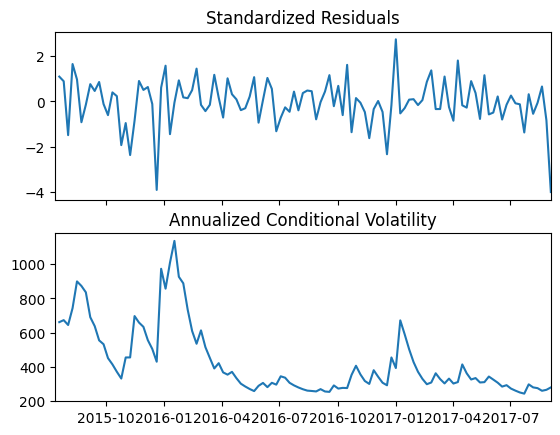

In [35]:
fig = res.plot(annualize="D")

In [36]:
# Análisis Residuos, graficar
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()

/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

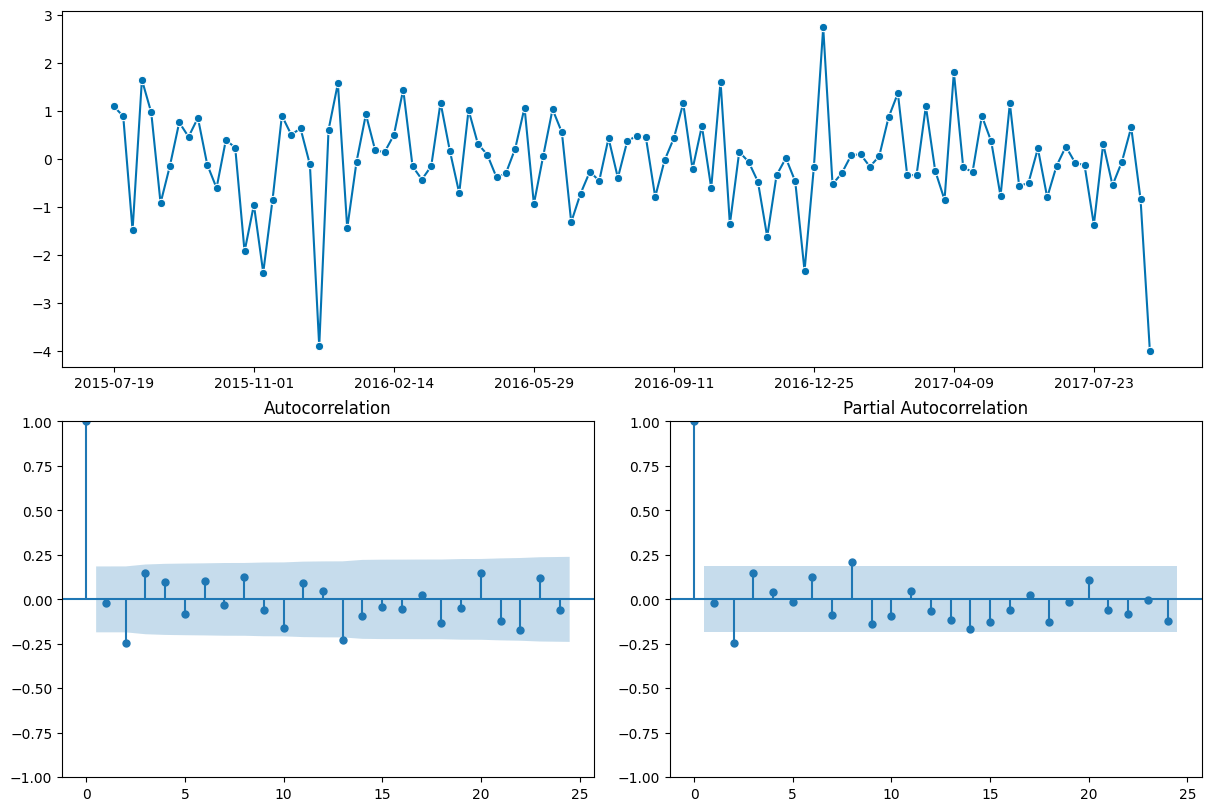

In [37]:
# plot
plot_correlations(mod1_std_resid)

/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

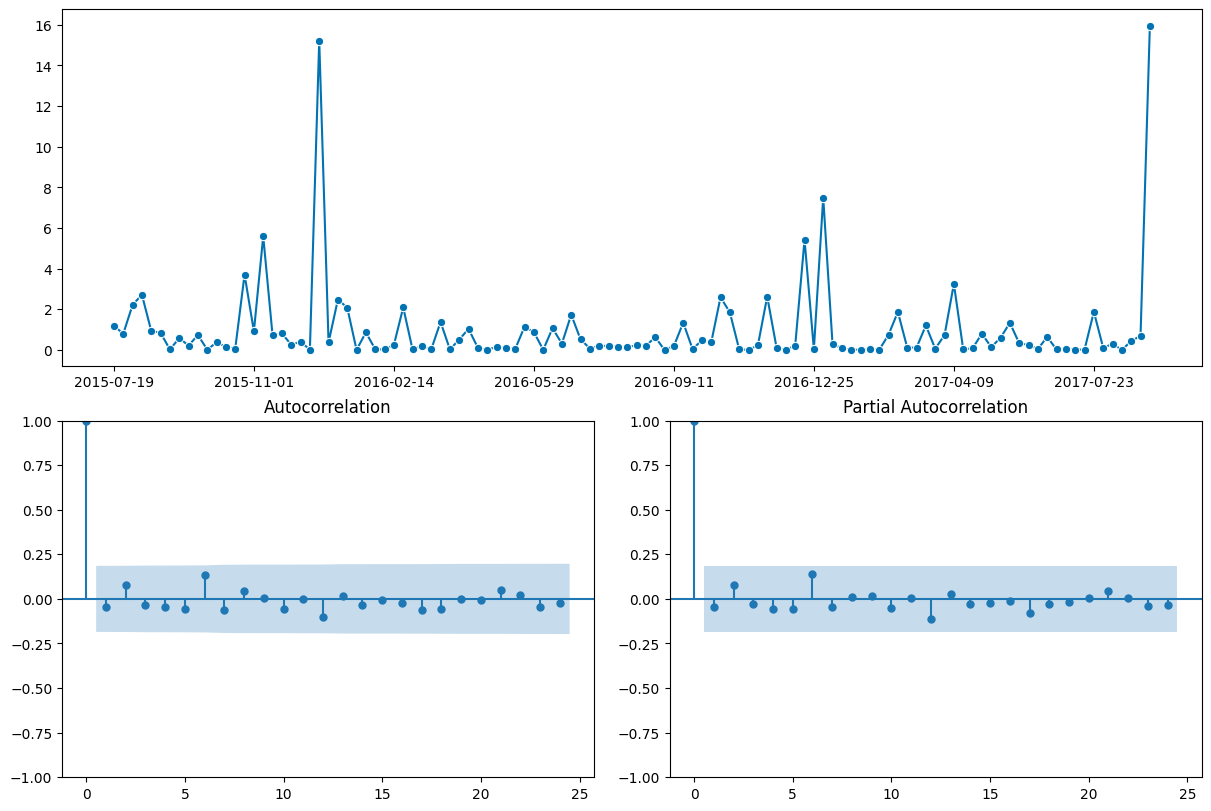

In [38]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid**2)

No tiene Garch

In [39]:
# testing Ljung-Box
# pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(mod1_std_resid**2, lags=[4,8,12], return_df=True)

,lb_stat,lb_pvalue
4,1.333388,0.855686
8,4.228599,0.835932
12,5.591209,0.935272


Más ruido blanco que antes, sigue sin tener Garch

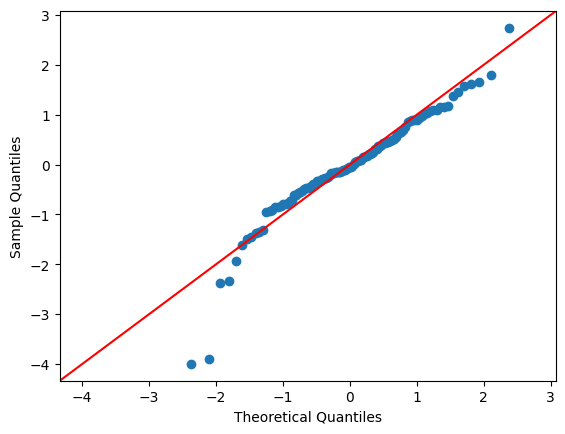

In [40]:
# qqplot normal,
sm.qqplot(mod1_std_resid,line='45')
plt.show()

Muy correlacionada, pero sigue teniendo algún error.

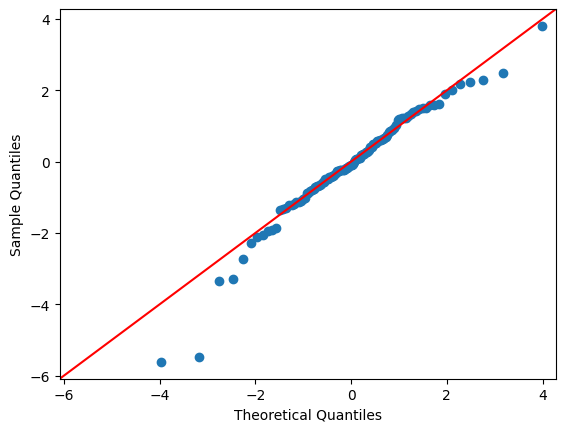

In [41]:
# qqplot t-student
sm.qqplot(mod1_std_resid,dist=stats.t,fit=True,line='45')
plt.show()

T-Student Asimétrica

In [42]:
from arch import arch_model
model1=arch_model(100*df_w_r['log_ret'].dropna(), p = 1, q = 1, #defino modelo, datos, p y q del garch
          mean = 'AR', lags=1, vol = 'GARCH', # autoregresivo con un retardo
          dist = 'skewt') # dist es la t asimetrica
res = model1.fit(update_freq=0, disp="off")
print(res.summary())

                                 AR - GARCH Model Results                                
Dep. Variable:                           log_ret   R-squared:                       0.037
Mean Model:                                   AR   Adj. R-squared:                  0.028
Vol Model:                                 GARCH   Log-Likelihood:               -511.219
Distribution:      Standardized Skew Student's t   AIC:                           1036.44
Method:                       Maximum Likelihood   BIC:                           1055.47
                                                   No. Observations:                  112
Date:                           Wed, Dec 20 2023   Df Residuals:                      110
Time:                                   12:05:49   Df Model:                            2
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/home/codespace/.python/current/lib/python3.10/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

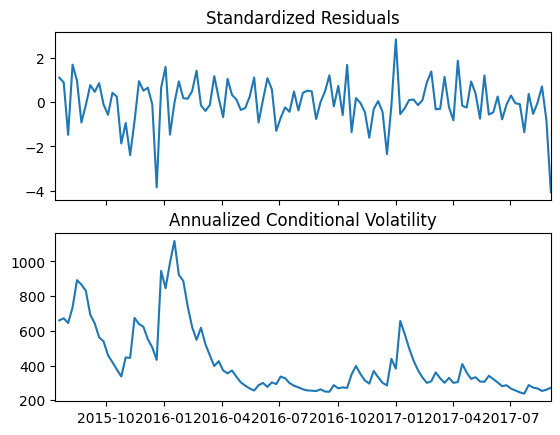

In [43]:
fig = res.plot(annualize="D")

In [44]:
# Análisis Residuos, la z 
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()

/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

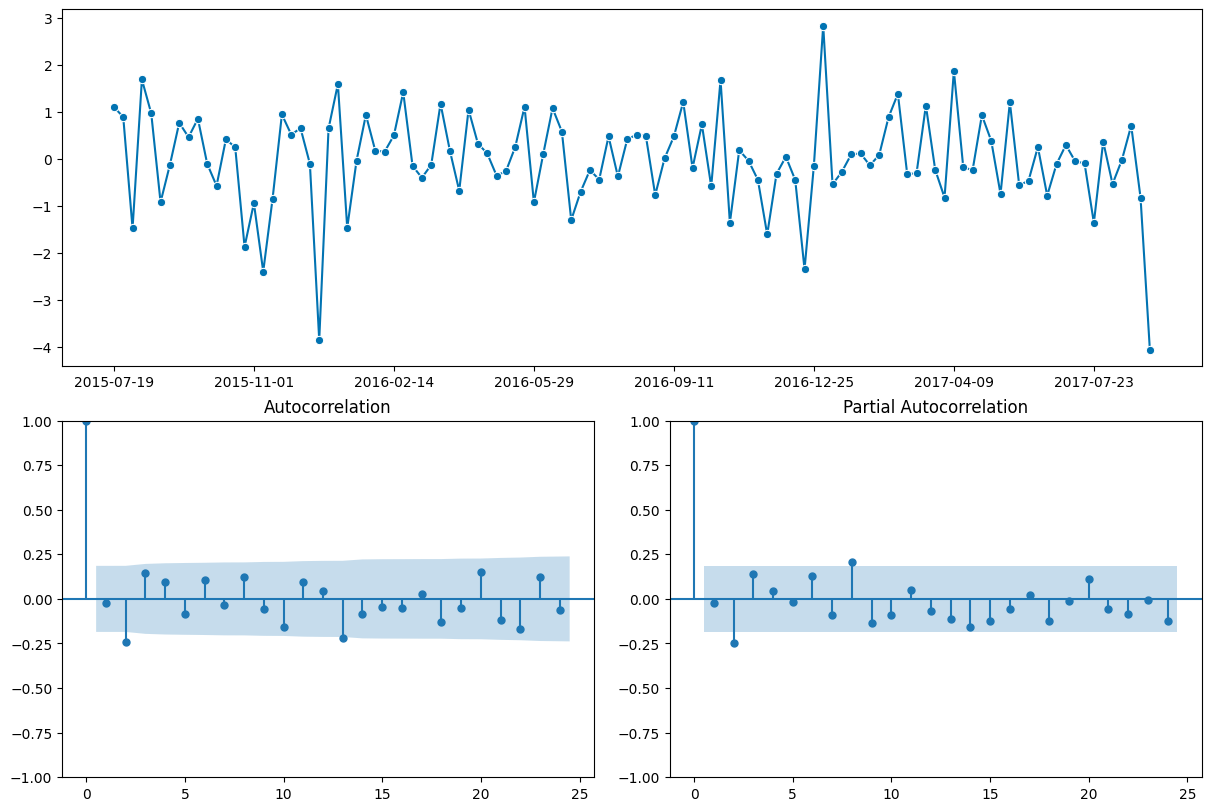

In [45]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid)

No tiene Ruido Blanco

/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/.python/current/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

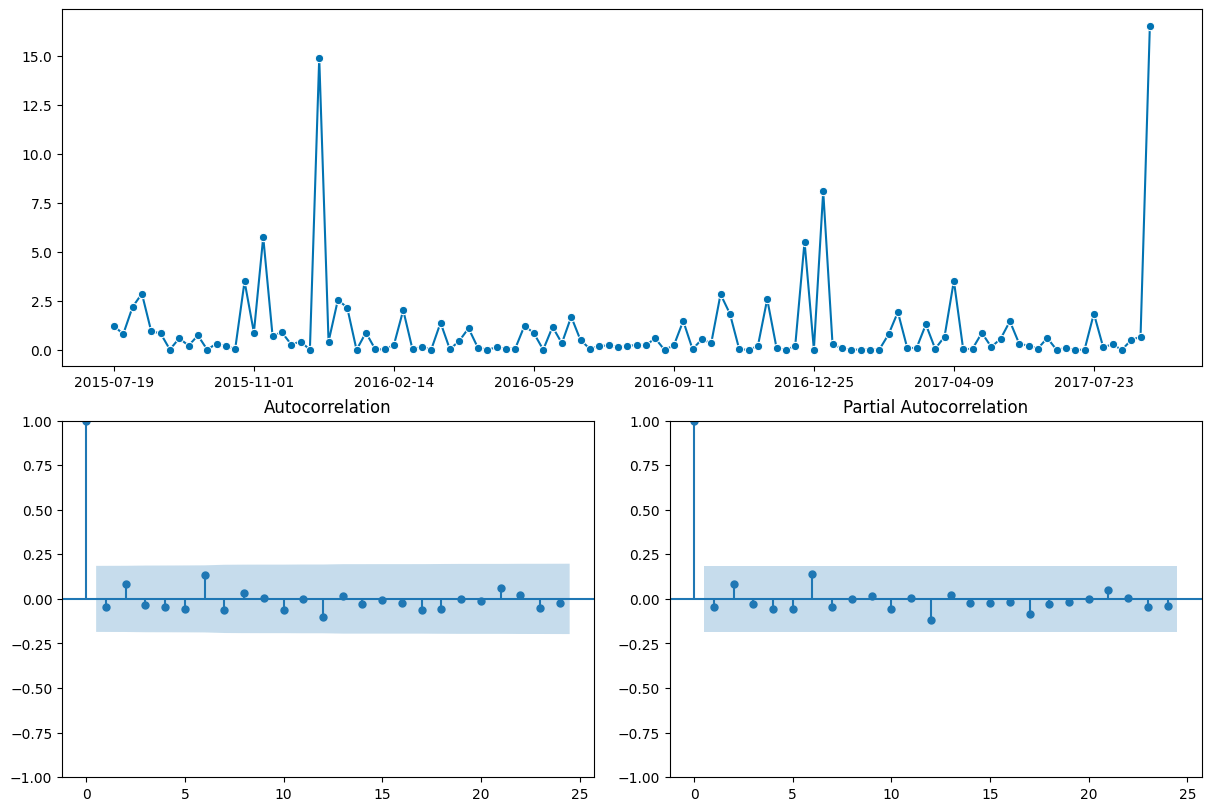

In [46]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid**2)

In [47]:
#
# testing Ljung-Box
# pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(mod1_std_resid**2, lags=[4,8,12], return_df=True)

,lb_stat,lb_pvalue
4,1.392242,0.845542
8,4.185074,0.840051
12,5.624534,0.933815


Estos valores altos, nos dice que no tiene Garch

<Axes: xlabel='ArrivalDate'>

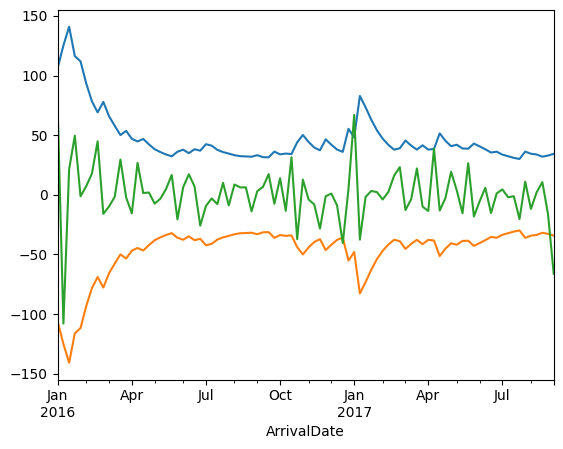

In [48]:
(2.0*res.conditional_volatility)["2016":].plot() # 2.0 es el intervalo
(-2.0*res.conditional_volatility)["2016":].plot()
(100*df_w_r['log_ret'].dropna())["2016":].plot()


Casi todos los valores estan dentro de los parametros que he estimado, eso es bueno.

### Forecast Volatility

In [49]:
# Predicción 4 días
forecasts = res.forecast(horizon=4, reindex=False)

In [50]:
# Mean, esta es la prediccion de la varianza diario
forecasts.mean

,h.1,h.2,h.3,h.4
ArrivalDate,,,,
2017-09-03,14.542066,-3.588774,0.472115,-0.43743


In [51]:
(forecasts.variance**0.5) # Prediccion/volatilidad diaria

,h.1,h.2,h.3,h.4
ArrivalDate,,,,
2017-09-03,39.702689,40.282553,39.929157,39.549207


In [52]:
# Volatilidad por 30 dias de bookings, para hacerlo mensual.
(forecasts.variance**0.5)*np.sqrt(30)

,h.1,h.2,h.3,h.4
ArrivalDate,,,,
2017-09-03,217.460583,220.63663,218.701001,216.619929


<Axes: >

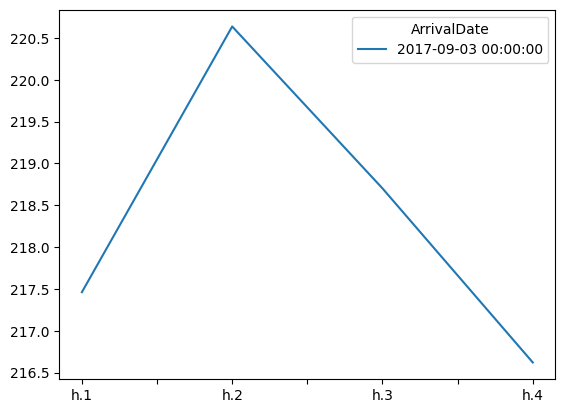

In [53]:
# Prediccion 20 días hacia delante
fvol = ((forecasts.variance**0.5)*1*np.sqrt(30)).T
fvol.plot()